In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
class CustomDataset(Dataset):
  def __init__(self, depth, step, data_type="train"):
    super(CustomDataset, self).__init__()
    self.x = []
    self.y = []

    data = np.genfromtxt("./data.txt", delimiter="")

    for i in range(depth, len(data) - 1):
      if data_type == "train":
        self.x.append(data[i-depth:i,0:4])
        self.y.append(data[i:i+step,3])
      elif data_type == "test":
        self.x.append(data[i-depth:i,4:8])
        self.y.append(data[i:i+step,7])
      else:
        raise Exception("Invalid data type. Choose either train or test.")
      
    self.x = torch.tensor(np.array(self.x)).float()
    self.y = torch.tensor(np.array(self.y)).float()

    # Max-Min Scaling
    self.data_max = torch.tensor(data).float().max()
    self.data_min = torch.tensor(data).float().min()

    self.x = (self.x - self.data_min) / (self.data_max - self.data_min)
    self.y = (self.y - self.data_min) / (self.data_max - self.data_min)
    
  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

  def rescale(self, data):
    return data * (self.data_max - self.data_min) + self.data_min

# load the data
dataset = CustomDataset(depth=5, step=2, data_type="train")
dataloader = DataLoader(dataset, batch_size = 32)

In [3]:
class CustomLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(CustomLSTM, self).__init__()

    # input size, hidden size
    self.input_size = input_size
    self.hidden_size = hidden_size

    # gate size
    gate_size = 4 * hidden_size

    # weight
    self.w_ih = nn.Parameter(torch.Tensor(self.input_size, gate_size))
    self.w_hh = nn.Parameter(torch.Tensor(self.hidden_size, gate_size))
    
    # bias
    self.b = nn.Parameter(torch.Tensor(gate_size))

    # weight initialization
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-stdv, stdv)

  def forward(self, x):
    # B : batch size, L : sequence length(depth)
    B, L = x.size(0), x.size(1)

    output = []

    # initial values
    h0 = torch.zeros(B, self.hidden_size)
    c0 = torch.zeros(B, self.hidden_size)

    for t in range(L):
      xt = x[:,t,:]
      gates = xt @ self.w_ih + h0 @ self.w_hh + self.b

      it = torch.sigmoid(gates[:,:self.hidden_size])
      ft = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
      gt = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
      ot = torch.sigmoid(gates[:,3*self.hidden_size:])

      ct = ft * c0 + it + gt
      ht = ot * torch.tanh(c0)

      # save as B x 1 x h
      output.append(ht.unsqueeze(1))

    # save as B x L x h
    output = torch.cat(output, dim=1)
    return output, (ht, ct)

In [4]:
class MultiStepPrediction(nn.Module):
  def __init__(self, input_size, hidden_size, step_size):
    super(MultiStepPrediction, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.step_size = step_size

    #self.lstm = CustomLSTM(input_size, hidden_size)
    self.lstm = nn.LSTM(self.input_size+self.step_size-1, self.hidden_size, 1, batch_first=True)
    self.fc1 = nn.Linear(self.hidden_size, 1)
    self.fc2 = nn.Linear(self.hidden_size, 1)

  def forward(self, x):
    # x : B x L x I => x : B x (L-1) x (I+s-1)
    _x1 = x[:,:-1,:] # B x (L-1) x I
    _x2 = x[:,1:,-(self.step_size-1)].unsqueeze(2) # B x (L-1) x (s-1)
    _x = torch.cat([_x1, _x2], dim=2) # B x (L-1) x (l+s-1)

    # first step prediction
    out1, (ht1, ct1) = self.lstm(_x)
    first_step = self.fc1(ht1.squeeze(0))

    _x = torch.cat([x[:,-1,:], first_step], dim=1) # B x 1 x (l+s-1)
    
    # second step prediction
    out2, (ht2, ct2) = self.lstm(_x.unsqueeze(1))
    second_step = self.fc2(ht2.squeeze(0))

    return torch.cat([first_step, second_step], dim=1)

In [5]:
model = MultiStepPrediction(input_size=4, hidden_size=4, step_size=2)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

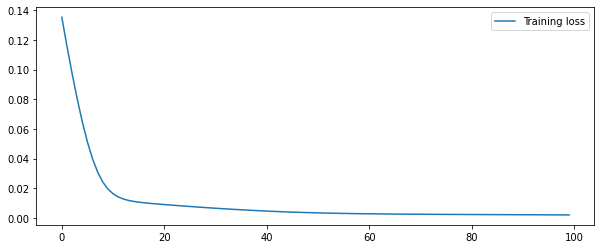

In [6]:
train_history = np.zeros(100)

for epoch in range(100):
  avg_loss = 0
  for i, data in enumerate(dataloader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    avg_loss += loss/32
  train_history[epoch] = avg_loss

fig = plt.figure(figsize=(10, 4))
plt.plot(train_history, label='Training loss')
plt.legend()
plt.show()

In [7]:
dataset = CustomDataset(depth=5, step=2, data_type="test")

label1 = []
label2 = []

output1 = []
output2 = []

for i in range(len(dataset)):
  x, y = dataset.__getitem__(i)
  x = torch.reshape(x, (1, 5, 4))
  label1.append(y[0])
  label2.append(y[1])
  output = model(x)

  output1.append(output[:,0].detach().numpy())
  output2.append(output[:,1].detach().numpy())

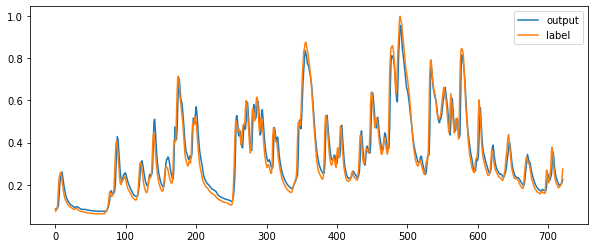

In [8]:
# first step prediction result

fig = plt.figure(figsize=(10, 4))
plt.plot(output1, label="output")
plt.plot(label1, label="label")
plt.legend()
plt.show()

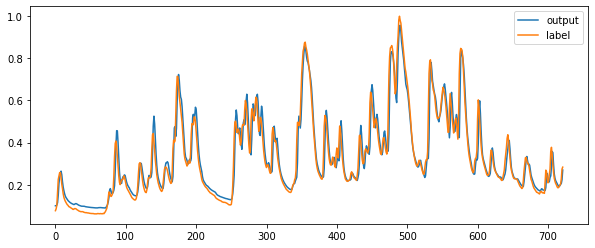

In [9]:
# second step prediction result

fig = plt.figure(figsize=(10, 4))
plt.plot(output2, label="output")
plt.plot(label2, label="label")
plt.legend()
plt.show()